The data extraction notebook was about extracting all the relevant features from the dataset
We have extracted MFCCs and spectral centroids for 7994/8000 tracks
Now we will apply treatments to these features, starting by dimensionality reduction and clustering

In [2]:
# Make imports
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score, homogeneity_completeness_v_measure


C:\Users\jibbzed\AppData\Local\Temp\ipykernel_10480\2687164998.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


We have 2 dataframes to load : the features extracted from the tracks, and the metadata about the tracks (namely the genre)

In [3]:
# Load the data into dataframes
features = pd.read_csv('data/more_extracted_features.csv')
metadata = pd.read_csv('data/metadata.csv')

# Remove the tracks that were not found in the features dataset from the metadata
metadata = metadata[metadata['track_id'].isin(features['track_id'])]

print (metadata.shape)
print (features.shape)

(7994, 4)
(7994, 302)


We will first try to reduce the dimensionality of our data from 148 to just 2 in order to be able to visualize the data points
Then we'll apply a simple K-means clustering (and it's even better because we know the expected numebr of clusters) on our data to see how it does
Note that reducing the dimensionality from 148 to 2 will lead to massive loss and therefore the clustering might not be great
We could (and will probably) also reduce the dimensionality to a bit more like 10 features, apply a K-means and evaluate it by comparing the clusters to the real values for the genre (the evaluation will be a bit of a pain) 
In order to find the best number of dimensions we can apply PCA to all features (not reducing anything) and checking the contributions from the different attributes to the PCA
Note that for the data to be mapped we need to have the dataframes ordered in the same way : the first element of the metadata corresponds to the same track as the first element of the features dataframe
For this, it is possible to merge the two dataframes in oder to have all in one

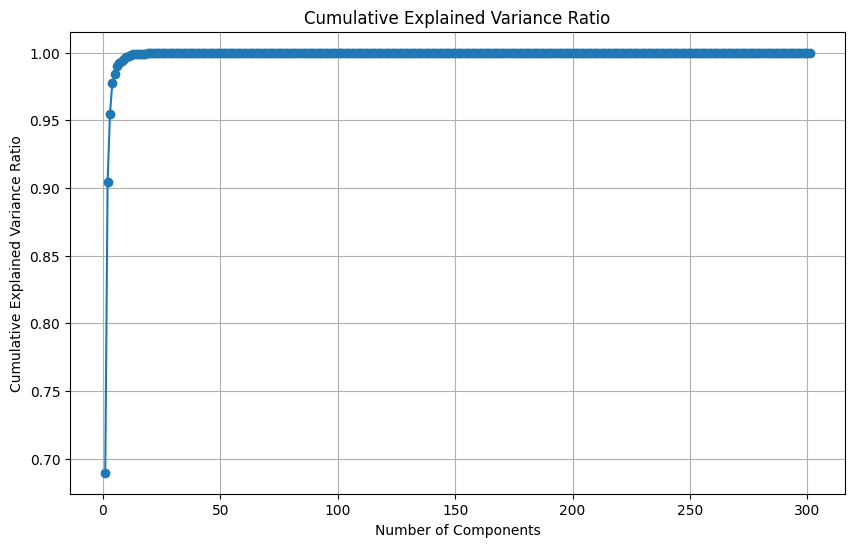

array([ True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [4]:
# Drop the track_id column first
X = features.drop(columns=['track_id']).values

# Dimensionality reduction (PCA)
pca = PCA(n_components=X.shape[1])  # Keep all components initially
X_pca = pca.fit_transform(X)

# Calculate cumulative explained variance ratio
cumulative_explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance_ratio) + 1), cumulative_explained_variance_ratio, marker='o', linestyle='-')
plt.title('Cumulative Explained Variance Ratio')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

cumulative_explained_variance_ratio < 0.99

As we can see, 90% of the variance can be explained with 1 component, and 99% with 6, so 2 components is enough for our use case especially because it allows us to visualise the data (it is not as good as with the "smaller" dataset with less features where 99% of the variance couldl be explained by 3 features)
Now that we have our clusters, we can evaluate them, not visually but mathematically speaking

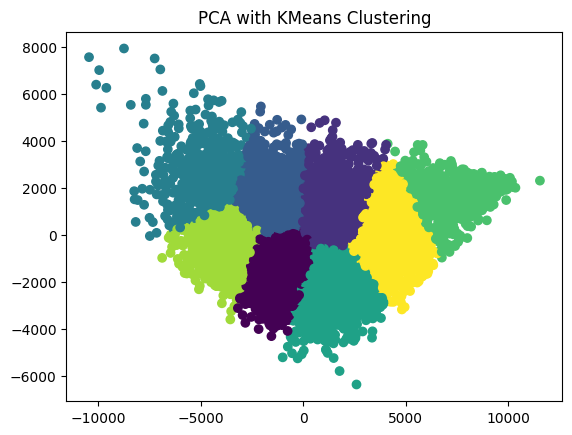

In [5]:
# Dimensionality reduction using PCA
# First, reducing to 2 dimensions for visualization

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Clustering using KMeans with 8 clusters because we know that there are 8 genres
n_clusters = 8
kmeans = KMeans(n_clusters=8)
clusters = kmeans.fit(X_pca)

# Visualize the clusters
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters.labels_)
plt.title('PCA with KMeans Clustering')
plt.show()


Even with only 2 components for PCA the Kmeans yields a very good result as we can see on the graph
The fact that the clusters are very well defined means that it should be pretty easy to classify the data and also that the features we extracted are relevant !
I will however try to check how many dimensions should be kept and try PCA with that

In [6]:
# Evaluate clustering performance
true_labels = metadata['track_genre'].values

silhouette = silhouette_score(X_pca, clusters.labels_)
ari = adjusted_rand_score(true_labels, clusters.labels_)
nmi = normalized_mutual_info_score(true_labels, clusters.labels_)
h, c, v = homogeneity_completeness_v_measure(true_labels, clusters.labels_)

print(f"Silhouette Score: {silhouette}")
print(f"Homogeneity: {h}")
print(f"Completeness: {c}")
print(f"V-measure: {v}")
print(f"Adjusted Rand Index (ARI): {ari}")
print(f"Normalized Mutual Information (NMI): {nmi}")

Silhouette Score: 0.3363637042258673
Homogeneity: 0.10628926708084595
Completeness: 0.1090339601139419
V-measure: 0.10764412050121458
Adjusted Rand Index (ARI): 0.06312583717450997
Normalized Mutual Information (NMI): 0.10764412050121458


#TODO : analyse the results of the clustering
Let's interpret each of the evaluation metrics based on the provided values:
About the same results as with the smaller dataset, meaning the clusters are okay but not great => we can hope that by reducing the dimensionality to about 10 components we will have better clustering and therefore that this dataset with more features will be better than the previous one

We can try with 10 dimensions for clustering and see how it affects the metrics (because with 10 dimensions we have more than 99% of the variance explained)

In [7]:
# Perform PCA
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)

# Clustering using KMeans with 8 clusters because we know that there are 8 genres
n_clusters = 8
kmeans = KMeans(n_clusters=8)
clusters = kmeans.fit(X_pca)

# We can't visualize the clusters

# Evaluate clustering performance
silhouette = silhouette_score(X_pca, clusters.labels_)
ari = adjusted_rand_score(true_labels, clusters.labels_)
nmi = normalized_mutual_info_score(true_labels, clusters.labels_)
h, c, v = homogeneity_completeness_v_measure(true_labels, clusters.labels_)

print(f"Silhouette Score: {silhouette}")
print(f"Homogeneity: {h}")
print(f"Completeness: {c}")
print(f"V-measure: {v}")
print(f"Adjusted Rand Index (ARI): {ari}")
print(f"Normalized Mutual Information (NMI): {nmi}")

Silhouette Score: 0.2623016122678433
Homogeneity: 0.10923864864687641
Completeness: 0.1122389531768348
V-measure: 0.11071847870500857
Adjusted Rand Index (ARI): 0.06540989554147242
Normalized Mutual Information (NMI): 0.11071847870500857


The results are a bit worse it seems like, so we could just stick with our 2 components
Either way once we get to the classification task we won't be using PCA anymore, we will probably use all the features for our classifiers => this can be discussed, how many parameters we give to the model can affect the performances

Now that we have done the clustering part, we can start the actual classification task
We will train two different models namely SVM and Random Forest (debatable but those are the ones I choose, we could compare them to a neural network of some kind)
The data has already been split in 3 sets for us, and the sets are supposedly very well balanced in order to make our lives easier, so we will start by getting our 3 sets and then we will train our models, using cross validation and the validation set to tune the hyperparameters

In [8]:
# Split our dataset in 3 parts: train, validation and test  

# First, we need to merge the features and metadata dataframes
data = pd.merge(features, metadata, on='track_id')

# Split the data into train, validation and test sets
train = data[data['set'] == 'training']
validation = data[data['set'] == 'validation']  
test = data[data['set'] == 'test']

# Sanity check
print(train.shape)
print(validation.shape)
print(test.shape)

# Drop the track_id, track_genre, genre_id and set columns
X_train = train.drop(columns=['track_id', 'track_genre', 'set', 'genre_id']).values
X_validation = validation.drop(columns=['track_id', 'track_genre', 'set', 'genre_id']).values
X_test = test.drop(columns=['track_id', 'track_genre', 'set', 'genre_id']).values

# Split the data into data and labels, labels being the track_genre column
y_train = train['track_genre'].values
y_validation = validation['track_genre'].values
y_test = test['track_genre'].values

# Sanity check
print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)
print(y_train.shape)
print(y_validation.shape)
print(y_test.shape)

(6394, 305)
(800, 305)
(800, 305)
(6394, 301)
(800, 301)
(800, 301)
(6394,)
(800,)
(800,)


Tried using GridSearch in order to automate the hyperparameter tuning process
The idea is that it performs 5 fold cross validation with all possible combinations of hyperparameters that is given to it, and ends up outputting the best performing model
Note that because I use cross validation I should merge the training and validation datasets because the validation is done "on the training data" with cross validation
We could also try to use PCA before inputing the data so that the training becomes quicker, especially because we have seen that the variance in the dataset can be explained mostly with 5/10 dimensions instead of 300


Let's try to train the model without PCA first and then with PCA, keeping in mind that the PCA version will always be worse but can be way quicker to train
Especially now that we have more than 300 features, training the models will take about twice as long as with the previous dataset that contained only 150 features

In [11]:
# First we want to train SVM model with 5 fold cross validation
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Merge the train and validation sets for cross validation
X_cross_validation = np.concatenate((X_train, X_validation))
y_cross_validation = np.concatenate((y_train, y_validation))

'''
# Use PCA to reduce the dimensionality of the data
pca = PCA(n_components=5)
X_cross_validation = pca.fit_transform(X_cross_validation)
X_test = pca.transform(X_test)
'''

# Be sure training samples are shuffled.
X_cross_validation, y_cross_validation = skl.utils.shuffle(X_cross_validation, y_cross_validation, random_state=42)

# Standardize features by removing the mean and scaling to unit variance.
scaler = skl.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X_cross_validation)
scaler.transform(X_test)

# Define the parameter grid
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3, cv=5)

# Fit the model
grid.fit(X_cross_validation, y_cross_validation)

# Print the best parameters
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)
#print(grid.best_index_)
#print(grid.scorer_)
#print(grid.n_splits_)
#print(grid.refit_time_)
#print(grid.cv_results_)

# Make predictions
y_pred = grid.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.368 total time=   2.8s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.393 total time=   3.5s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.379 total time=   3.5s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.361 total time=   3.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.372 total time=   3.3s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.372 total time=   2.9s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.368 total time=   3.4s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.366 total time=   2.7s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.358 total time=   2.6s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.371 total time=   2.7s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.343 total time=   3.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

d:\Cours\Echange Milan\Audio Pattern Recognition\music-genre-recognition\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Cours\Echange Milan\Audio Pattern Recognition\music-genre-recognition\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Cours\Echange Milan\Audio Pattern Recognition\music-genre-recognition\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

13% accuracy is basically random (because we have 8 clusters) so it's basically shit, let's try with the random forest
After checking the FMA dataset github, some things can be useful to improve the performance of the classifiers : standardizing the data, and shuffling the samples before training !
Seems like the random forest yields way way better results but random forest is not affected by data normalization => it is probably the problem therefore I need to test with normalization
Random Forest yields around 40/45% accuracy which is not that bad considering that the task at hand is quite complex
After testing with shuffling and normalization, we get 40/45% accuracy on the SVM ! That was in fact the problem !
Let's try normalization + shuffling on the random forest, though it should not yield very different result because random forest is not affected by normalization => it's a combination of binary trees so it should not change much

In [10]:
# Let's now try to train a Random Forest model
from sklearn.ensemble import RandomForestClassifier

'''
# Use PCA to reduce the dimensionality of the data
pca = PCA(n_components=5)
X_cross_validation = pca.fit_transform(X_cross_validation)
X_test = pca.transform(X_test)
'''

# Define the parameter grid
param_grid = {'n_estimators': [10, 100, 1000], 'max_features': ['auto', 'sqrt', 'log2']}
grid = GridSearchCV(RandomForestClassifier(), param_grid, refit=True, verbose=3, cv=5)

# Fit the model
grid.fit(X_cross_validation, y_cross_validation)

# Print the best parameters
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)
#print(grid.best_index_)
#print(grid.scorer_)
#print(grid.n_splits_)
#print(grid.refit_time_)
#print(grid.cv_results_)

# Make predictions
y_pred = grid.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ..max_features=auto, n_estimators=10;, score=nan total time=   0.0s
[CV 2/5] END ..max_features=auto, n_estimators=10;, score=nan total time=   0.0s
[CV 3/5] END ..max_features=auto, n_estimators=10;, score=nan total time=   0.0s
[CV 4/5] END ..max_features=auto, n_estimators=10;, score=nan total time=   0.0s
[CV 5/5] END ..max_features=auto, n_estimators=10;, score=nan total time=   0.0s
[CV 1/5] END .max_features=auto, n_estimators=100;, score=nan total time=   0.0s
[CV 2/5] END .max_features=auto, n_estimators=100;, score=nan total time=   0.0s
[CV 3/5] END .max_features=auto, n_estimators=100;, score=nan total time=   0.0s
[CV 4/5] END .max_features=auto, n_estimators=100;, score=nan total time=   0.0s
[CV 5/5] END .max_features=auto, n_estimators=100;, score=nan total time=   0.0s
[CV 1/5] END max_features=auto, n_estimators=1000;, score=nan total time=   0.0s
[CV 2/5] END max_features=auto, n_estimators=1000

d:\Cours\Echange Milan\Audio Pattern Recognition\music-genre-recognition\venv\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Cours\Echange Milan\Audio Pattern Recognition\music-genre-recognition\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Cours\Echange Milan\Audio Pattern Recognition\music-genre-recognition\venv\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "d:\Cours\Echange Mi

{'max_features': 'sqrt', 'n_estimators': 1000}
RandomForestClassifier(n_estimators=1000)
0.5423969280165777
               precision    recall  f1-score   support

   Electronic       0.49      0.58      0.53       100
 Experimental       0.29      0.19      0.23       100
         Folk       0.22      0.21      0.21       100
      Hip-Hop       0.58      0.60      0.59       100
 Instrumental       0.43      0.47      0.45       100
International       0.45      0.49      0.47       100
          Pop       0.36      0.35      0.36       100
         Rock       0.59      0.59      0.59       100

     accuracy                           0.43       800
    macro avg       0.43      0.43      0.43       800
 weighted avg       0.43      0.43      0.43       800



As expected the shuffled and scaled version does not change much to the performance of the random forest
I seem to have noticed a slight lowering of training time though, which I don't know how to explain, but could be explained by the scaling because it makes it easier to manipulate the numbers (wild guess, probably wrong)
Now that we know why the SVM performed so poorly we can redo the training on the "smaller" dataset to see if extracting more features was in fact worth it